In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import interpolate

## Bộ dữ liệu kênh truyền

Mô hình kênh truyền vô tuyến được chọn là mô hình Vehicular-A, với:
- Tần số sóng mang 2.1 GHz
- Băng thông 1.6 MHz
- Tốc độ thiết bị người dùng là 50 km/h.

Mô hình kênh truyền bao gồm 2 bộ dữ liệu:
- Đáp ứng kênh truyền lý tưởng
- Đáp ứng kênh truyền nhiễu với SNR = 12

Mỗi bộ dữ liệu có 4000 mẫu đáp ứng kênh trong miền thời gian - tần số, 
với 72 sóng mang con và 14 khe thời gian.

In [16]:
# Mô hình kênh truyền lý tưởng
perfect = loadmat("data/Perfect_H_40000.mat")['My_perfect_H']
# Mô hình kênh truyền nhiễu
noisy_input = loadmat("data/My_noisy_H_12.mat")["My_noisy_H"]

n_subs = 72
n_slots = 14
snr = 12

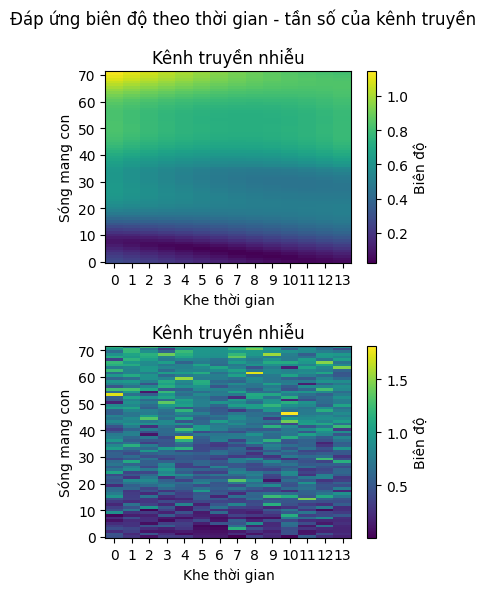

In [17]:
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(4, 6)
fig.suptitle('Đáp ứng biên độ theo thời gian - tần số của kênh truyền')

# Đáp ứng biên độ của kênh truyền lý tưởng
perfect_response = np.abs(perfect[0].squeeze())
# Đáp ứng biên độ của kênh truyền nhiễu
noisy_response = np.abs(noisy_input[0].squeeze())

# Vẽ đáp ứng
cax = axes[0].imshow(perfect_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[0].set_title('Kênh truyền nhiễu')
cax = axes[1].imshow(noisy_response, aspect='auto', origin='lower', interpolation='none')
fig.colorbar(cax, label='Biên độ')
axes[1].set_title('Kênh truyền nhiễu')

for ax in axes:
    ax.set_ylabel('Sóng mang con')
    ax.set_xlabel('Khe thời gian')
    ax.set_xticks(np.arange(0, n_slots, step=1))
    ax.set_yticks(np.arange(0, n_subs, step=10))

plt.tight_layout()
plt.show()

## Cấu trúc sắp xếp pilot

Số lượng pilot ảnh hưởng đến dữ liệu nội suy kênh nhiễu, mà kênh nhiễu là ngõ vào của mô hình máy học. 

Do đó, ứng với số lượng pilot khác nhau, ta cũng có một tập dữ liệu huấn luyện và một mạng neuron tối ưu riêng.

Số lượng pilot được chọn tiêu biểu từ tập {8, 16, 24, 36, 48}

In [ ]:
n_pilots = 16

In [19]:
if n_pilots == 48:
    idx = [14 * i for i in range(1, 72, 6)] + [4 + 14 * i for i in range(4, 72, 6)] + \
            [7 + 14 * i for i in range(1, 72, 6)] + [11 + 14 * i for i in range(4, 72, 6)]
elif n_pilots == 16:
    idx = [4 + 14 * i for i in range(1, 72, 9)] + [9 + 14 * i for i in range(4, 72, 9)]
elif n_pilots == 24:
    idx = [14 * i for i in range(1, 72, 9)] + [6 + 14 * i for i in range(4, 72, 9)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 9)]
elif n_pilots == 8:
    idx = [4 + 14 * i for i in range(5, 72, 18)] + [9 + 14 * i for i in range(8, 72, 18)]
elif n_pilots == 36:
    idx = [14 * i for i in range(1, 72, 6)] + [6 + 14 * i for i in range(4, 72, 6)] + [11 + 14 * i for i in
                                                                                        range(1, 72, 6)]
P = np.zeros(n_slots*n_subs)
for i in idx: P[i] = 5
P.reshape((n_slots, n_subs))
T, F = np.meshgrid(range(1, n_slots+1), range(1, n_subs+1))

r = [x // 14 for x in idx]
c = [x % 14 for x in idx]

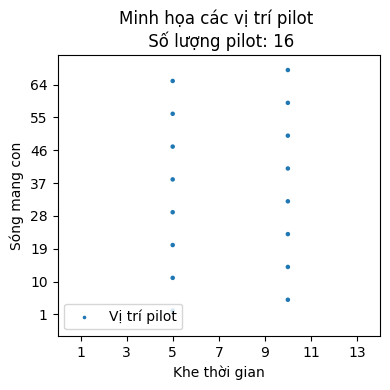

In [20]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(T, F, P, label='Vị trí pilot')
ax.legend()
ax.set_title("Minh họa các vị trí pilot \n Số lượng pilot: %d" % n_pilots)

ax.set_xlabel('Khe thời gian')
ax.set_ylabel('Sóng mang con')
ax.set_xlim(0, n_slots)
ax.set_ylim(-5, n_subs)
ax.set_xticks(range(1, n_slots, 2))
ax.set_yticks(range(1, n_subs, 9))

plt.tight_layout()
plt.show()

## Chuẩn bị dữ liệu cho huấn luyện

### 1. Nội suy kênh nhiễu từ pilot và Định dạng kênh nhiễu

In [21]:
noisy_image = np.zeros((40000, 72, 14, 2))

# Tách ảnh thành phần thực và phần ảo
noisy_image[:, :, :, 0] = np.real(noisy_input)
noisy_image[:, :, :, 1] = np.imag(noisy_input)

In [22]:
interp_noisy = np.zeros((40000, 72, 14, 2))

for i in range(len(noisy_input)):
    z = [noisy_image[i, j, k, 0] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(72), range(14))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 0] = z_intp.T

    z = [noisy_image[i, j, k, 1] for j, k in zip(r, c)]
    f = interpolate.Rbf(np.array(r).astype(float), np.array(c).astype(float), z, function='gaussian')
    X, Y = np.meshgrid(range(72), range(14))
    z_intp = f(X, Y)
    interp_noisy[i, :, :, 1] = z_intp.T

interp_noisy = np.concatenate((interp_noisy[:, :, :, 0], 
                               interp_noisy[:, :, :, 1]), axis=0).reshape(80000, 72, 14, 1)

### 2. Định dạng dữ liệu kênh lý tưởng

In [23]:
perfect_image = np.zeros((len(perfect), 72, 14, 2))
perfect_image[:, :, :, 0] = np.real(perfect)
perfect_image[:, :, :, 1] = np.imag(perfect)
perfect_image = np.concatenate((perfect_image[:, :, :, 0], 
                                perfect_image[:, :, :, 1]), axis=0)
perfect_image = perfect_image.reshape(2 * len(perfect), 72, 14, 1)

### 3. Chia tập huấn luyện và kiểm tra

In [40]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_label, val_label = \
    train_test_split(interp_noisy, perfect_image, test_size=0.2)

## Huấn luyện

Huấn luyện mô hình với tập dữ liệu huấn luyện đã chuẩn bị, với:
- Mô hình kênh truyền Vehicular-A
- Số lượng pilot thuộc tập {8, 16, 24, 36, 48}
- SNR = 12 dB

In [42]:
import models
from models import interpolation, SRCNN_train, SRCNN_predict
import importlib
importlib.reload(models)

channel_model = "VehA"

SRCNN_train(train_data, train_label, val_data, val_label, channel_model, n_pilots, snr)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 72, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 72, 14, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 14, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 72, 14, 1)      │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1: val_loss improved from inf to 0.02719, saving model to SRCNN_check.keras

Epoch 2: val_loss improved from 0.02719 to 0.02618, saving model to SRCNN_check.keras

Epoch 3: val_loss improved from 0.02618 to 0.02569, saving model to SRCNN_check.keras

Epoch 4: val_loss improved from 0.02569 to 0.02443, saving model to SRCNN_check.keras

Epoch 5: val_loss improved from 0.02443 to 0.02419, saving model to SRCNN_check.keras

Epoch 6: val_loss improved from 0.02419 to 0.02395, saving model to SRCNN_check.keras

Epoch 7: val_loss improved from 0.02395 to 0.02392, saving model to SRCNN_check.keras

Epoch 8: val_loss improved from 0.02392 to 0.02371, saving model to SRCNN_check.keras

Epoch 9: val_loss improved from 0.02371 to 0.02360, saving model to SRCNN_check.keras

Epoch 10: val_loss improved from 0.02360 to 0.02331, saving model to SRCNN_check.keras

Epoch 11: val_loss improved from 0.02331 to 0.02320, saving model to SRCNN_check.keras

Epoch 12: val_loss improved from 0.0232

KeyboardInterrupt: 

## Kiểm tra mô hình

In [ ]:
# Từ mô hình đã huấn luyện
# Ước lượng kênh truyền của tập dữ liệu huấn luyện
srcnn_pred_train = SRCNN_predict(train_data, channel_model, n_pilots, snr)
# Ước lượng kênh truyền của tập dữ liệu kiểm tra
srcnn_pred_validation = SRCNN_predict(val_data, channel_model, n_pilots, snr)